In [1]:
%env DDEBACKEND=tensorflow.compat.v1

import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



env: DDEBACKEND=tensorflow.compat.v1
Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
A = 2
C = 10


def get_initial_loss(model):
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    losshistory, train_state = model.train(0)
    return losshistory.loss_train[0]


def pde(x, y):
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_tt - C ** 2 * dy_xx


def func(x):
    x, t = np.split(x, 2, axis=1)
    return np.sin(np.pi * x) * np.cos(C * np.pi * t) + np.sin(A * np.pi * x) * np.cos(
        A * C * np.pi * t
    )


In [3]:
def fourier_feature():
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
    ic_1 = dde.IC(geomtime, func, lambda _, on_initial: on_initial)
    # do not use dde.NeumannBC here, since `normal_derivative` does not work with temporal coordinate.
    ic_2 = dde.OperatorBC(
        geomtime,
        lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
        lambda x, _: np.isclose(x[1], 0),
    )
    data = dde.data.TimePDE(
        geomtime,
        pde,
        [bc, ic_1, ic_2],
        num_domain=360,
        num_boundary=360,
        num_initial=360,
        solution=func,
        num_test=10000,
    )

    layer_size = [2] + [100] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.maps.STMsFFN(
        layer_size, activation, initializer, sigmas_x=[1], sigmas_t=[1, 10]
    )
    net.apply_feature_transform(lambda x: (x - 0.5) * 2 * np.sqrt(3))

    model = dde.Model(data, net)
    initial_losses = get_initial_loss(model)
    loss_weights = 5 / initial_losses
    model.compile(
        "adam",
        lr=0.001,
        metrics=["l2 relative error"],
        loss_weights=loss_weights,
        decay=("inverse time", 2000, 0.9),
    )
    pde_residual_resampler = dde.callbacks.PDEResidualResampler(period=1)
    losshistory, train_state = model.train(
        epochs=10000, callbacks=[pde_residual_resampler], display_every=500
    )

    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [4]:
def default_MLP():
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
    ic_1 = dde.IC(geomtime, func, lambda _, on_initial: on_initial)
    # do not use dde.NeumannBC here, since `normal_derivative` does not work with temporal coordinate.
    ic_2 = dde.OperatorBC(
        geomtime,
        lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
        lambda x, _: np.isclose(x[1], 0),
    )
    data = dde.data.TimePDE(
        geomtime,
        pde,
        [bc, ic_1, ic_2],
        num_domain=360,
        num_boundary=360,
        num_initial=360,
        solution=func,
        num_test=10000,
    )

    layer_size = [2] + [100] * 3 + [1]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(
        layer_size, activation, initializer,
#         sigmas_x=[1], sigmas_t=[1, 10]
    )
#     net.apply_feature_transform(lambda x: (x - 0.5) * 2 * np.sqrt(3))

    model = dde.Model(data, net)
    initial_losses = get_initial_loss(model)
    loss_weights = 5 / initial_losses
    model.compile(
        "adam",
        lr=0.001,
        metrics=["l2 relative error"],
        loss_weights=loss_weights,
        decay=("inverse time", 2000, 0.9),
    )
    pde_residual_resampler = dde.callbacks.PDEResidualResampler(period=1)
    losshistory, train_state = model.train(
        epochs=10000, callbacks=[pde_residual_resampler], display_every=500
    )

    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building Spatio-temporal Multi-scale Fourier Feature Network...


c:\users\saransh\saransh_softwares\python_3.9\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+362=362. 
  warnings.warn("The balance properties of Sobol' points require "
c:\users\saransh\saransh_softwares\python_3.9\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\saransh\saransh_softwares\python_3.9\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 3.668528 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [6.37e+05, 7.21e-02, 1.41e+00, 7.99e+01]    [7.26e+05, 7.21e-02, 1.41e+00, 7.99e+01]    [1.15e+00]    

Best model at step 0:
  train loss: 6.37e+05
  test loss: 7.26e+05
  test metric: [1.15e+00]

'train' took 1.729230 s

Compiling model...
'compile' took 1.396763 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [6.70e+00, 5.36e+00, 5.22e+00, 2.82e+00]    [6.30e+00, 5.36e+00, 5.22e+00, 2.82e+00]    [1.04e+00]    
500       [4.68e-02, 3.07e-03, 1.06e-03, 4.21e-05]    [1.18e-01, 3.07e-03, 1.06e-03, 4.21e-05]    [8.92e-01]    
1000      [2.14e-02, 2.07e-03, 2.64e-04, 5.57e-05]    [6.83e-02, 2.07e-03, 2.64e-04, 5.57e-05]    [8.27e-01]    
1500      [1.73e-02, 1.49e-03, 1.64e-04

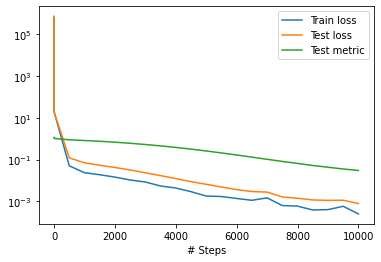

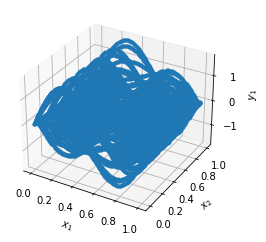

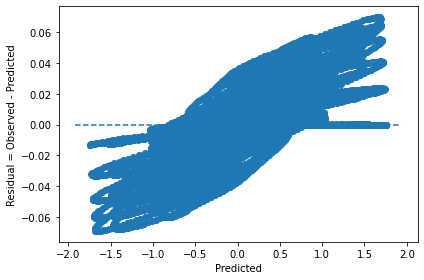

In [5]:
fourier_feature()

Compiling model...
Building feed-forward neural network...
'build' took 0.044300 s



c:\users\saransh\saransh_softwares\python_3.9\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+362=362. 
  warnings.warn("The balance properties of Sobol' points require "
c:\users\saransh\saransh_softwares\python_3.9\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\saransh\saransh_softwares\python_3.9\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.492186 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.35e+00, 7.77e-03, 9.79e-01, 3.79e-02]    [8.14e-01, 7.77e-03, 9.79e-01, 3.79e-02]    [1.01e+00]    

Best model at step 0:
  train loss: 2.37e+00
  test loss: 1.84e+00
  test metric: [1.01e+00]

'train' took 0.418851 s

Compiling model...
'compile' took 0.396698 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [5.66e+01, 6.92e+00, 5.53e+00, 4.03e+00]    [4.31e+01, 6.92e+00, 5.53e+00, 4.03e+00]    [1.01e+00]    
500       [9.84e-05, 2.42e-02, 5.07e+00, 7.97e-03]    [9.74e-05, 2.42e-02, 5.07e+00, 7.97e-03]    [9.99e-01]    
1000      [2.56e-04, 2.72e-02, 5.06e+00, 6.25e-03]    [2.56e-04, 2.72e-02, 5.06e+00, 6.25e-03]    [9.99e-01]    
1500      [4.27e-04, 3.00e-02, 5.06e+00

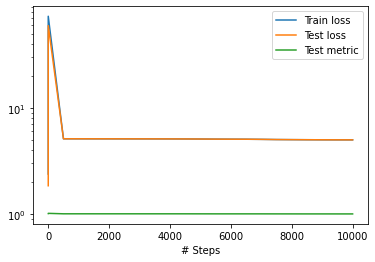

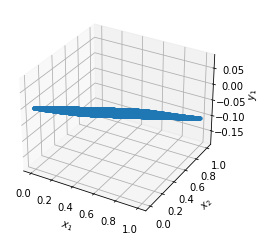

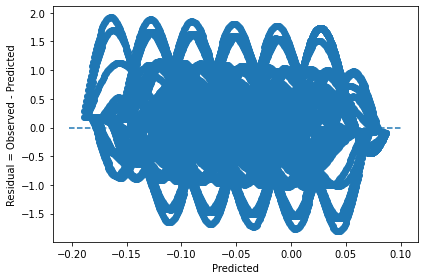

In [6]:
default_MLP()